In [5]:
# run.ipynb

# ===== 1. 라이브러리 임포트 =====
import numpy as np
import xarray as xr
from utils import prepare_quantile_maps_pytorch, prepare_all_quantile_maps, prepare_all_quantile_maps_gpu
from train import train_bias_correction, get_default_config

LR_PATH = r"/home/visionlab01/young/syh/hj3/data/tas_restormer_prediction_v2.nc"
# LR_PATH = "/raid/tasmax_ACCESS-CM2_0p25_exact.nc"
HR_PATH = r"./data/tas_all_methods_comparison.nc"
# xr.open_dataset(LR_PATH)

lr_result = xr.open_dataset(LR_PATH).tmax_predicted
hr_result = xr.open_dataset(LR_PATH).tmax_target
ref_start, ref_end = '1992-01-01', '2012-12-31'
val_start, val_end = '2013-01-01', '2014-12-31'

# lr_result = lr_result.sel(
#     lat=slice(BBOX['lat_min'], BBOX['lat_max']),
#     lon=slice(BBOX['lon_min'], BBOX['lon_max'])
# )
# hr_result = hr_result.sel(
#     lat=slice(BBOX['lat_min'], BBOX['lat_max']),
#     lon=slice(BBOX['lon_min'], BBOX['lon_max'])
# )
lr_train_regrid = lr_result.sel(time=slice(ref_start, ref_end))
hr_train = hr_result.sel(time=slice(ref_start, ref_end))
lr_val_regrid = lr_result.sel(time=slice(val_start, val_end))
hr_val = hr_result.sel(time=slice(val_start, val_end))


# # run.ipynb

# # ===== 1. 라이브러리 임포트 =====
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
from utils import prepare_all_quantile_maps
from train import train_bias_correction, get_default_config

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(1)}")




# ===== 3. 분위수 맵 준비 (캐싱) =====
print("\n" + "="*60)
print("Preparing Quantile Maps")
print("="*60)

cache_dir = 'cache_tas_gpu_v2'
n_quantiles = 500

data = prepare_all_quantile_maps_gpu(
    lr_train_regrid, hr_train,
    lr_val_regrid, hr_val,
    n_quantiles=n_quantiles,
    cache_dir=cache_dir,
    force_recompute=False,  # True로 하면 재계산,
    device='cuda:1'
)

lr_q_train, hr_q_train = data['train']
lr_q_val, hr_q_val = data['val']
lr_mean, lr_std, hr_mean, hr_std = data['stats']
quantiles = data['quantiles']


PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB

Preparing Quantile Maps
Computing quantile maps (GPU accelerated)

[1/4] LR Train
🚀 GPU accelerated quantile computation on cuda:1
   Total pixels: 56,000
   Batch size: 1,000


Computing quantiles: 100%|██████████| 56/56 [00:17<00:00,  3.18it/s]



[2/4] HR Train
🚀 GPU accelerated quantile computation on cuda:1
   Total pixels: 56,000
   Batch size: 1,000


Computing quantiles: 100%|██████████| 56/56 [00:17<00:00,  3.21it/s]



[3/4] LR Val
🚀 GPU accelerated quantile computation on cuda:1
   Total pixels: 56,000
   Batch size: 1,000


Computing quantiles: 100%|██████████| 56/56 [00:14<00:00,  3.81it/s]



[4/4] HR Val
🚀 GPU accelerated quantile computation on cuda:1
   Total pixels: 56,000
   Batch size: 1,000


Computing quantiles: 100%|██████████| 56/56 [00:14<00:00,  3.80it/s]



📊 Computing normalization statistics...
   LR: mean=294.0536, std=6.9044
   HR: mean=293.8999, std=7.2371

💾 Saving to cache: cache_tas_gpu_v2/quantile_maps_q500_gpu.pkl
✅ Quantile maps ready!
   Train: (500, 200, 280)
   Val:   (500, 200, 280)


In [6]:
# run.ipynb

# ===== 1. 라이브러리 임포트 =====
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
from train import train_bias_correction, get_default_config
from utils import prepare_all_quantile_maps_gpu

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(1)}")




# ===== 3. 분위수 맵 준비 (캐싱) =====
print("\n" + "="*60)
print("Preparing Quantile Maps")
print("="*60)

cache_dir = 'cache_tas_gpu_v2'
n_quantiles = 500

data = prepare_all_quantile_maps_gpu(
    lr_train_regrid, hr_train,
    lr_val_regrid, hr_val,
    n_quantiles=n_quantiles,
    cache_dir=cache_dir,
    force_recompute=False  # True로 하면 재계산
  )

lr_q_train, hr_q_train = data['train']
lr_q_val, hr_q_val = data['val']
lr_mean, lr_std, hr_mean, hr_std = data['stats']
quantiles = data['quantiles']

print(f"\n✅ Quantile maps ready!")
print(f"   Train shape: {lr_q_train.shape}")
print(f"   Val shape:   {lr_q_val.shape}")
print(f"   N quantiles: {n_quantiles}")

# ===== 4. 설정 =====
print("\n" + "="*60)
print("Configuration")
print("="*60)

config = get_default_config()

# 커스터마이즈
config['device'] = 'cuda:1'
config['plot_every'] = 2
config['checkpoint_dir'] = 'checkpoints/vit_tas_v3'
config['plot_dir'] = 'plots/vit_tas_v3'

print("\n📋 Training Configuration:")
for k, v in config.items():
    print(f"   {k}: {v}")

# ===== 5. 학습 시작 =====
print("\n" + "="*60)
print("🚀 Starting ViT Training")
print("="*60)
# ===== 5. 학습 =====
# config = get_default_config()
trainer = train_bias_correction(
    lr_q_train, hr_q_train, lr_q_val, hr_q_val,
    (lr_mean, lr_std), (hr_mean, hr_std), quantiles,
    config
)

# ===== 6. 결과 확인 =====
print("\n" + "="*60)
print("📊 Training Results")
print("="*60)

print(f"✅ Training completed!")
print(f"   Best validation loss: {trainer.best_loss:.6f}")
print(f"   Final train loss: {trainer.train_losses[-1]:.6f}")
print(f"   Final val loss: {trainer.val_losses[-1]:.6f}")

# Loss 곡선 플롯
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, len(trainer.train_losses) + 1), trainer.train_losses, 
        'b-', label='Train Loss', alpha=0.7)
epochs_val = [i * config['plot_every'] for i in range(1, len(trainer.val_losses) + 1)]
ax.plot(epochs_val, trainer.val_losses, 'r-o', label='Val Loss', linewidth=2, markersize=6)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Progress', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.tight_layout()
plt.savefig('final_loss_curve_vit_tas_v2.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📁 Results saved to:")
print(f"   Checkpoints: {config['checkpoint_dir']}/")
print(f"   Plots: {config['plot_dir']}/")
print(f"   Best model: {config['checkpoint_dir']}/best_model.pth")

# ===== 7. 체크포인트 로드 테스트 =====
print("\n" + "="*60)
print("🔍 Testing Checkpoint Load")
print("="*60)

checkpoint = torch.load(f"{config['checkpoint_dir']}/best_model.pth")
print(f"Checkpoint info:")
print(f"   Epoch: {checkpoint['epoch']}")
print(f"   Val Loss: {checkpoint['val_loss']:.6f}")
print(f"   LR stats: mean={checkpoint['lr_stats'][0]:.4f}, std={checkpoint['lr_stats'][1]:.4f}")
print(f"   HR stats: mean={checkpoint['hr_stats'][0]:.4f}, std={checkpoint['hr_stats'][1]:.4f}")

print("\n✅ All done! 🎉")

/home/visionlab01/young/syh/hj3/engine.py:113: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB

Preparing Quantile Maps
📂 Loading from cache: cache_tas_gpu_v2/quantile_maps_q500_gpu.pkl
✅ Cache loaded successfully

✅ Quantile maps ready!
   Train shape: (500, 200, 280)
   Val shape:   (500, 200, 280)
   N quantiles: 500

Configuration

📋 Training Configuration:
   batch_size: 4
   num_workers: 4
   patch_size: 4
   embed_dim: 256
   depth: 4
   num_heads: 4
   dropout: 0.1
   num_epochs: 200
   lr: 5e-05
   weight_decay: 0.01
   device: cuda:1
   checkpoint_dir: checkpoints/vit_tas_v3
   plot_dir: plots/vit_tas_v3
   plot_every: 2

🚀 Starting ViT Training
🚀 Training for 200 epochs
   Device: cuda:1
   Params: 3.87M


Training:   0%|          | 0/125 [00:00<?, ?it/s]/home/visionlab01/young/syh/hj3/engine.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 125/125 [00:10<00:00, 12.11it/s, loss=0.0401]
/home/visionlab01/young/syh/hj3/engine.py:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 1/200
  Train: 0.407907
  Val:   0.048112
✅ Best model saved (val_loss: 0.048112)


Training: 100%|██████████| 125/125 [00:10<00:00, 12.13it/s, loss=0.027] 



Epoch 2/200
  Train: 0.032737
  Val:   0.031031
✅ Best model saved (val_loss: 0.031031)


Training: 100%|██████████| 125/125 [00:10<00:00, 12.11it/s, loss=0.0443]


Epoch 3: 0.024226


Training: 100%|██████████| 125/125 [00:10<00:00, 12.18it/s, loss=0.0176]



Epoch 4/200
  Train: 0.020040
  Val:   0.024250
✅ Best model saved (val_loss: 0.024250)


Training: 100%|██████████| 125/125 [00:10<00:00, 12.04it/s, loss=0.0139]


Epoch 5: 0.017038


Training: 100%|██████████| 125/125 [00:10<00:00, 12.15it/s, loss=0.0176]



Epoch 6/200
  Train: 0.016135
  Val:   0.017651
✅ Best model saved (val_loss: 0.017651)


Training: 100%|██████████| 125/125 [00:10<00:00, 12.07it/s, loss=0.0138]


Epoch 7: 0.013908


Training: 100%|██████████| 125/125 [00:10<00:00, 12.15it/s, loss=0.0126]



Epoch 8/200
  Train: 0.013444
  Val:   0.017389
✅ Best model saved (val_loss: 0.017389)


Training: 100%|██████████| 125/125 [00:10<00:00, 12.02it/s, loss=0.0112]


Epoch 9: 0.012079


Training: 100%|██████████| 125/125 [00:10<00:00, 12.16it/s, loss=0.01]   



Epoch 10/200
  Train: 0.011346
  Val:   0.014579
✅ Best model saved (val_loss: 0.014579)


Training: 100%|██████████| 125/125 [00:10<00:00, 12.03it/s, loss=0.00971]


Epoch 11: 0.011462


Training: 100%|██████████| 125/125 [00:10<00:00, 12.16it/s, loss=0.00908]



Epoch 12/200
  Train: 0.010321
  Val:   0.013923
✅ Best model saved (val_loss: 0.013923)


Training: 100%|██████████| 125/125 [00:10<00:00, 12.05it/s, loss=0.00868]


Epoch 13: 0.009608


Training: 100%|██████████| 125/125 [00:10<00:00, 12.15it/s, loss=0.00854]



Epoch 14/200
  Train: 0.009293
  Val:   0.013263
✅ Best model saved (val_loss: 0.013263)


Training: 100%|██████████| 125/125 [00:10<00:00, 11.98it/s, loss=0.00771]


Epoch 15: 0.009320


Training: 100%|██████████| 125/125 [00:10<00:00, 12.11it/s, loss=0.00848]



Epoch 16/200
  Train: 0.008629
  Val:   0.013506


Training: 100%|██████████| 125/125 [00:10<00:00, 12.03it/s, loss=0.00993]


Epoch 17: 0.008102


Training: 100%|██████████| 125/125 [00:10<00:00, 12.08it/s, loss=0.00876]



Epoch 18/200
  Train: 0.008147
  Val:   0.013712


Training: 100%|██████████| 125/125 [00:10<00:00, 12.04it/s, loss=0.00827]


Epoch 19: 0.007904


Training: 100%|██████████| 125/125 [00:10<00:00, 12.10it/s, loss=0.00649]



Epoch 20/200
  Train: 0.007503
  Val:   0.012130
✅ Best model saved (val_loss: 0.012130)


Training: 100%|██████████| 125/125 [00:10<00:00, 12.01it/s, loss=0.00627]


Epoch 21: 0.007130


Training: 100%|██████████| 125/125 [00:10<00:00, 12.10it/s, loss=0.00613]



Epoch 22/200
  Train: 0.006991
  Val:   0.011926


/home/visionlab01/young/syh/hj3/engine.py:235: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{self.plot_dir}/epoch_{epoch:03d}_stats.png', dpi=150)


✅ Best model saved (val_loss: 0.011926)


Training: 100%|██████████| 125/125 [00:10<00:00, 12.02it/s, loss=0.00574]


Epoch 23: 0.006739


Training: 100%|██████████| 125/125 [00:10<00:00, 12.09it/s, loss=0.00642]



Epoch 24/200
  Train: 0.007832
  Val:   0.011291
✅ Best model saved (val_loss: 0.011291)


Training: 100%|██████████| 125/125 [00:10<00:00, 11.97it/s, loss=0.00594]


Epoch 25: 0.006483


Training: 100%|██████████| 125/125 [00:10<00:00, 12.11it/s, loss=0.00651]



Epoch 26/200
  Train: 0.006511
  Val:   0.010845
✅ Best model saved (val_loss: 0.010845)


Training: 100%|██████████| 125/125 [00:10<00:00, 12.00it/s, loss=0.00614]


Epoch 27: 0.006174


Training: 100%|██████████| 125/125 [00:10<00:00, 12.10it/s, loss=0.0068] 



Epoch 28/200
  Train: 0.006432
  Val:   0.010823
✅ Best model saved (val_loss: 0.010823)


Training: 100%|██████████| 125/125 [00:10<00:00, 12.01it/s, loss=0.00575]


Epoch 29: 0.006166


Training: 100%|██████████| 125/125 [00:10<00:00, 12.11it/s, loss=0.00548]



Epoch 30/200
  Train: 0.006472
  Val:   0.010760
✅ Best model saved (val_loss: 0.010760)


Training: 100%|██████████| 125/125 [00:10<00:00, 12.01it/s, loss=0.00611]


Epoch 31: 0.005642


Training: 100%|██████████| 125/125 [00:10<00:00, 12.11it/s, loss=0.00522]



Epoch 32/200
  Train: 0.005594
  Val:   0.009919
✅ Best model saved (val_loss: 0.009919)


Training: 100%|██████████| 125/125 [00:10<00:00, 11.98it/s, loss=0.00522]


Epoch 33: 0.005538


Training: 100%|██████████| 125/125 [00:10<00:00, 12.12it/s, loss=0.00553]



Epoch 34/200
  Train: 0.005452
  Val:   0.009184
✅ Best model saved (val_loss: 0.009184)


Training: 100%|██████████| 125/125 [00:10<00:00, 12.03it/s, loss=0.00503]


Epoch 35: 0.005798


Training: 100%|██████████| 125/125 [00:10<00:00, 12.11it/s, loss=0.00717]



Epoch 36/200
  Train: 0.005162
  Val:   0.009520


Training: 100%|██████████| 125/125 [00:10<00:00, 11.98it/s, loss=0.00534]


Epoch 37: 0.005060


Training: 100%|██████████| 125/125 [00:10<00:00, 12.08it/s, loss=0.00458]



Epoch 38/200
  Train: 0.005172
  Val:   0.010095


Training: 100%|██████████| 125/125 [00:10<00:00, 11.99it/s, loss=0.00494]


Epoch 39: 0.005080


Training: 100%|██████████| 125/125 [00:10<00:00, 12.08it/s, loss=0.00423]



Epoch 40/200
  Train: 0.004696
  Val:   0.010073


Training: 100%|██████████| 125/125 [00:10<00:00, 12.02it/s, loss=0.00449]


Epoch 41: 0.004875


Training: 100%|██████████| 125/125 [00:10<00:00, 12.10it/s, loss=0.0042] 



Epoch 42/200
  Train: 0.004559
  Val:   0.009822


Training: 100%|██████████| 125/125 [00:10<00:00, 12.00it/s, loss=0.00437]


Epoch 43: 0.004556


Training: 100%|██████████| 125/125 [00:10<00:00, 12.09it/s, loss=0.00441]



Epoch 44/200
  Train: 0.004477
  Val:   0.009019
✅ Best model saved (val_loss: 0.009019)


Training: 100%|██████████| 125/125 [00:10<00:00, 11.96it/s, loss=0.00378]


Epoch 45: 0.004430


Training: 100%|██████████| 125/125 [00:10<00:00, 12.10it/s, loss=0.0041] 



Epoch 46/200
  Train: 0.004559
  Val:   0.012832


Training: 100%|██████████| 125/125 [00:10<00:00, 12.00it/s, loss=0.00384]


Epoch 47: 0.004433


Training: 100%|██████████| 125/125 [00:10<00:00, 12.09it/s, loss=0.00425]



Epoch 48/200
  Train: 0.004165
  Val:   0.009114


Training: 100%|██████████| 125/125 [00:10<00:00, 11.99it/s, loss=0.00356]


Epoch 49: 0.004346


Training: 100%|██████████| 125/125 [00:10<00:00, 12.09it/s, loss=0.00433]



Epoch 50/200
  Train: 0.004071
  Val:   0.009099


Training: 100%|██████████| 125/125 [00:10<00:00, 11.96it/s, loss=0.00403]


Epoch 51: 0.004123


Training: 100%|██████████| 125/125 [00:10<00:00, 12.05it/s, loss=0.00462]



Epoch 52/200
  Train: 0.003959
  Val:   0.008995
✅ Best model saved (val_loss: 0.008995)


Training: 100%|██████████| 125/125 [00:10<00:00, 11.99it/s, loss=0.00368]


Epoch 53: 0.003840


Training: 100%|██████████| 125/125 [00:10<00:00, 12.08it/s, loss=0.0039] 



Epoch 54/200
  Train: 0.003827
  Val:   0.008529
✅ Best model saved (val_loss: 0.008529)


Training: 100%|██████████| 125/125 [00:10<00:00, 12.01it/s, loss=0.00331]


Epoch 55: 0.003992


Training: 100%|██████████| 125/125 [00:10<00:00, 12.06it/s, loss=0.00422]



Epoch 56/200
  Train: 0.003927
  Val:   0.010171


Training: 100%|██████████| 125/125 [00:10<00:00, 11.97it/s, loss=0.00349]


Epoch 57: 0.003774


Training: 100%|██████████| 125/125 [00:10<00:00, 12.07it/s, loss=0.0037] 



Epoch 58/200
  Train: 0.003741
  Val:   0.008360
✅ Best model saved (val_loss: 0.008360)


Training: 100%|██████████| 125/125 [00:10<00:00, 11.97it/s, loss=0.004]  


Epoch 59: 0.003815


Training: 100%|██████████| 125/125 [00:10<00:00, 12.11it/s, loss=0.00378]



Epoch 60/200
  Train: 0.003851
  Val:   0.009150


Training: 100%|██████████| 125/125 [00:10<00:00, 11.97it/s, loss=0.00748]


Epoch 61: 0.003639


Training: 100%|██████████| 125/125 [00:10<00:00, 12.09it/s, loss=0.00332]



Epoch 62/200
  Train: 0.003617
  Val:   0.008497


Training: 100%|██████████| 125/125 [00:10<00:00, 11.98it/s, loss=0.00324]


Epoch 63: 0.003416


Training: 100%|██████████| 125/125 [00:10<00:00, 12.08it/s, loss=0.00388]



Epoch 64/200
  Train: 0.003510
  Val:   0.009870


Training: 100%|██████████| 125/125 [00:10<00:00, 11.94it/s, loss=0.00348]


Epoch 65: 0.003765


Training: 100%|██████████| 125/125 [00:10<00:00, 12.06it/s, loss=0.00318]



Epoch 66/200
  Train: 0.003404
  Val:   0.008614


Training: 100%|██████████| 125/125 [00:10<00:00, 11.98it/s, loss=0.00311]


Epoch 67: 0.003301


Training: 100%|██████████| 125/125 [00:10<00:00, 12.08it/s, loss=0.00376]



Epoch 68/200
  Train: 0.003594
  Val:   0.010303


Training: 100%|██████████| 125/125 [00:10<00:00, 11.97it/s, loss=0.00292]


Epoch 69: 0.003554


Training: 100%|██████████| 125/125 [00:10<00:00, 12.05it/s, loss=0.00311]



Epoch 70/200
  Train: 0.003226
  Val:   0.008773


Training: 100%|██████████| 125/125 [00:10<00:00, 11.99it/s, loss=0.00367]


Epoch 71: 0.003545


Training: 100%|██████████| 125/125 [00:10<00:00, 12.01it/s, loss=0.00305]



Epoch 72/200
  Train: 0.003263
  Val:   0.008433


Training: 100%|██████████| 125/125 [00:10<00:00, 12.00it/s, loss=0.00301]


Epoch 73: 0.003173


Training: 100%|██████████| 125/125 [00:10<00:00, 12.09it/s, loss=0.00393]



Epoch 74/200
  Train: 0.003143
  Val:   0.009061


Training: 100%|██████████| 125/125 [00:10<00:00, 11.93it/s, loss=0.00309]


Epoch 75: 0.003228


Training: 100%|██████████| 125/125 [00:10<00:00, 12.08it/s, loss=0.00293]



Epoch 76/200
  Train: 0.003118
  Val:   0.008271
✅ Best model saved (val_loss: 0.008271)


Training: 100%|██████████| 125/125 [00:10<00:00, 11.97it/s, loss=0.00308]


Epoch 77: 0.003145


Training: 100%|██████████| 125/125 [00:10<00:00, 12.07it/s, loss=0.00346]



Epoch 78/200
  Train: 0.003263
  Val:   0.009594


Training: 100%|██████████| 125/125 [00:10<00:00, 11.99it/s, loss=0.00314]


Epoch 79: 0.003146


Training: 100%|██████████| 125/125 [00:10<00:00, 12.07it/s, loss=0.0031] 



Epoch 80/200
  Train: 0.003003
  Val:   0.007993
✅ Best model saved (val_loss: 0.007993)


Training: 100%|██████████| 125/125 [00:10<00:00, 11.95it/s, loss=0.00308]


Epoch 81: 0.002961


Training: 100%|██████████| 125/125 [00:10<00:00, 12.00it/s, loss=0.00303]



Epoch 82/200
  Train: 0.003100
  Val:   0.008484


Training: 100%|██████████| 125/125 [00:10<00:00, 11.98it/s, loss=0.00302]


Epoch 83: 0.002950


Training: 100%|██████████| 125/125 [00:10<00:00, 12.05it/s, loss=0.00299]



Epoch 84/200
  Train: 0.002929
  Val:   0.007949
✅ Best model saved (val_loss: 0.007949)


Training: 100%|██████████| 125/125 [00:10<00:00, 11.98it/s, loss=0.00299]


Epoch 85: 0.002902


Training: 100%|██████████| 125/125 [00:10<00:00, 12.07it/s, loss=0.0031] 



Epoch 86/200
  Train: 0.002893
  Val:   0.008484


Training: 100%|██████████| 125/125 [00:10<00:00, 11.98it/s, loss=0.00262]


Epoch 87: 0.002871


Training: 100%|██████████| 125/125 [00:10<00:00, 12.05it/s, loss=0.00295]



Epoch 88/200
  Train: 0.002846
  Val:   0.008226


Training: 100%|██████████| 125/125 [00:10<00:00, 11.99it/s, loss=0.00263]


Epoch 89: 0.002820


Training: 100%|██████████| 125/125 [00:10<00:00, 12.05it/s, loss=0.00276]



Epoch 90/200
  Train: 0.002787
  Val:   0.007799
✅ Best model saved (val_loss: 0.007799)


Training: 100%|██████████| 125/125 [00:10<00:00, 11.96it/s, loss=0.00289]


Epoch 91: 0.002763


Training: 100%|██████████| 125/125 [00:10<00:00, 12.03it/s, loss=0.00251]



Epoch 92/200
  Train: 0.002724
  Val:   0.007716
✅ Best model saved (val_loss: 0.007716)


Training: 100%|██████████| 125/125 [00:10<00:00, 11.95it/s, loss=0.00316]


Epoch 93: 0.003157


Training: 100%|██████████| 125/125 [00:10<00:00, 12.04it/s, loss=0.0026] 



Epoch 94/200
  Train: 0.002763
  Val:   0.007939


Training: 100%|██████████| 125/125 [00:10<00:00, 11.97it/s, loss=0.00313]


Epoch 95: 0.002747


Training: 100%|██████████| 125/125 [00:10<00:00, 12.04it/s, loss=0.00279]



Epoch 96/200
  Train: 0.002672
  Val:   0.008135


Training: 100%|██████████| 125/125 [00:10<00:00, 11.99it/s, loss=0.0027] 


Epoch 97: 0.002637


Training: 100%|██████████| 125/125 [00:10<00:00, 12.03it/s, loss=0.00275]



Epoch 98/200
  Train: 0.002611
  Val:   0.007914


Training: 100%|██████████| 125/125 [00:10<00:00, 11.97it/s, loss=0.00247]


Epoch 99: 0.002593


Training: 100%|██████████| 125/125 [00:10<00:00, 12.04it/s, loss=0.00249]



Epoch 100/200
  Train: 0.002576
  Val:   0.007815


Training: 100%|██████████| 125/125 [00:10<00:00, 11.98it/s, loss=0.00268]


Epoch 101: 0.002759


Training: 100%|██████████| 125/125 [00:10<00:00, 12.06it/s, loss=0.0054] 



Epoch 102/200
  Train: 0.002570
  Val:   0.007813


Training: 100%|██████████| 125/125 [00:10<00:00, 11.97it/s, loss=0.00283]


Epoch 103: 0.002565


Training: 100%|██████████| 125/125 [00:10<00:00, 12.00it/s, loss=0.0023] 



Epoch 104/200
  Train: 0.002560
  Val:   0.007091
✅ Best model saved (val_loss: 0.007091)


Training: 100%|██████████| 125/125 [00:10<00:00, 11.92it/s, loss=0.00252]


Epoch 105: 0.002492


Training: 100%|██████████| 125/125 [00:10<00:00, 12.02it/s, loss=0.00224]



Epoch 106/200
  Train: 0.002641
  Val:   0.007664


Training: 100%|██████████| 125/125 [00:10<00:00, 12.00it/s, loss=0.00345]


Epoch 107: 0.002617


Training: 100%|██████████| 125/125 [00:10<00:00, 12.05it/s, loss=0.00264]



Epoch 108/200
  Train: 0.002538
  Val:   0.007015
✅ Best model saved (val_loss: 0.007015)


Training: 100%|██████████| 125/125 [00:10<00:00, 11.95it/s, loss=0.00259]


Epoch 109: 0.002502


Training: 100%|██████████| 125/125 [00:10<00:00, 12.03it/s, loss=0.00269]



Epoch 110/200
  Train: 0.002486
  Val:   0.007460


Training: 100%|██████████| 125/125 [00:10<00:00, 11.92it/s, loss=0.00217]


Epoch 111: 0.002396


Training: 100%|██████████| 125/125 [00:10<00:00, 12.04it/s, loss=0.00242]



Epoch 112/200
  Train: 0.002372
  Val:   0.007391


Training: 100%|██████████| 125/125 [00:10<00:00, 11.97it/s, loss=0.00217]


Epoch 113: 0.002347


Training: 100%|██████████| 125/125 [00:10<00:00, 12.01it/s, loss=0.0021] 



Epoch 114/200
  Train: 0.002332
  Val:   0.007617


Training: 100%|██████████| 125/125 [00:10<00:00, 11.96it/s, loss=0.00219]


Epoch 115: 0.002327


Training: 100%|██████████| 125/125 [00:10<00:00, 12.04it/s, loss=0.00214]



Epoch 116/200
  Train: 0.002305
  Val:   0.007151


Training: 100%|██████████| 125/125 [00:10<00:00, 11.94it/s, loss=0.00225]


Epoch 117: 0.002386


Training:   8%|▊         | 10/125 [00:01<00:15,  7.42it/s, loss=0.00219]


KeyboardInterrupt: 

In [3]:
# run.ipynb - 새로운 셀 추가
# ===== 편이보정 적용 (Inference) =====
# config['device'] = 'cuda:1'
print("\n" + "="*60)
print("🔬 BIAS CORRECTION INFERENCE")
print("="*60)

from inference import run_bias_correction
from inference2 import run_bias_correction2
from model import SimpleViT
import numpy as np
import xarray as xr
from train import train_bias_correction, get_default_config
config = get_default_config()

# 모델 설정 (학습 시와 동일하게!)
model_config = {
    'img_size': 200,  # 실제 이미지 크기
    'patch_size': config['patch_size'],
    'in_chans': 1,
    'out_chans': 1,
    'embed_dim': config['embed_dim'],
    'depth': config['depth'],
    'num_heads': config['num_heads'],
    'dropout': config['dropout']
}

# 편이보정 실행
lr_corrected = run_bias_correction2(
    lr_data_path=r"/home/visionlab01/young/IR DATASET/tasmax_future_projection_restormer_ssp245.nc",
    checkpoint_path=r"/home/visionlab01/young/syh/hj3/checkpoints/vit_tmax_v3/best_model.pth",
    output_path='/raid/vit_daily_tasmax_future_245_v3.nc',
    model_class=SimpleViT,
    model_config=model_config,
    n_quantiles=500,
    device='cuda:1',
    batch_size=32,
    var_name = "tasmax_predicted",
    restore_extremes=False,  # True로 하면 극값 복원,
    quantile_map_path = None
)




🔬 BIAS CORRECTION INFERENCE
🚀 Starting Bias Correction Pipeline (Fixed Historical CDF)


ValueError: ❌ Historical quantile map not found!
   Expected path: None
   You must provide pre-computed historical quantile maps.
   Run training first to generate these maps.

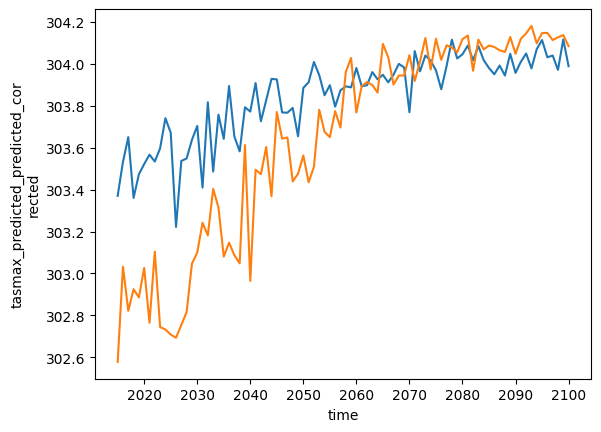

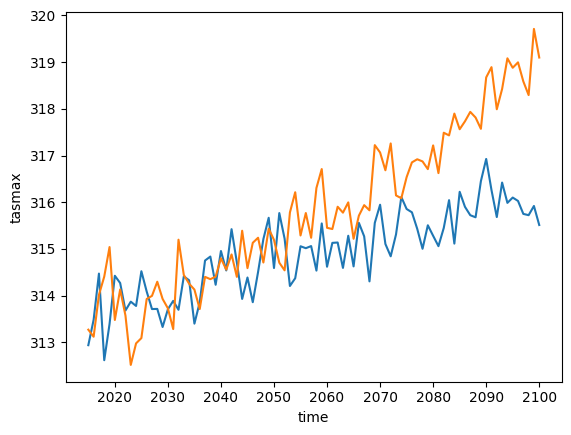

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
ds1 = xr.open_dataset('/raid/vit_daily_tasmax_future_245_v3.nc')
ds1.tasmax_predicted_predicted_corrected.resample(time="YS").max(dim='time').mean(dim=['lat', 'lon']).plot()  # 예시: 시간에 따른 최대값 플롯
ds2 = xr.open_dataset('/raid/vit_daily_tasmax_future_585_v3.nc')
ds2.tasmax_predicted_predicted_corrected.resample(time="YS").max(dim='time').mean(dim=['lat', 'lon']).plot()  # 예시: 시간에 따른 최대값 플롯
plt.show()
ds3 = xr.open_dataset('/raid/tasmax_day_ACCESS-CM2_ssp245_NEX.nc')
ds4 = xr.open_dataset('/raid/tasmax_day_ACCESS-CM2_ssp585_NEX.nc')
# lat_min=-50.0, lat_max=-0.0, lon_min=110.0, lon_max=180.0
ds3 = ds3.sel(
    lat=slice(-50.0, -0.0),
    lon=slice(110.0, 180.0)
)
ds4 = ds4.sel(
    lat=slice(-50.0, -0.0),
    lon=slice(110.0, 180.0)
)
ds3.tasmax.resample(time="YS").max(dim='time').mean(dim=['lat', 'lon']).plot()
ds4.tasmax.resample(time="YS").max(dim='time').mean(dim=['lat', 'lon']).plot()
plt.show()


In [22]:
ds2

<xarray.Dataset> Size: 7GB
Dimensions:                               (time: 31411, lat: 200, lon: 280)
Coordinates:
  * time                                  (time) datetime64[ns] 251kB 2015-01...
  * lat                                   (lat) float64 2kB -49.88 ... -0.125
  * lon                                   (lon) float64 2kB 110.1 ... 179.9
Data variables:
    tasmax_predicted_predicted_corrected  (time, lat, lon) float32 7GB ...

In [19]:
ds1.tasmax_predicted_corrected.std(), ds2.tasmax_predicted_corrected.std()

(<xarray.DataArray 'tasmax_predicted_corrected' ()> Size: 8B
 array(35.3573761),
 <xarray.DataArray 'tasmax_predicted_corrected' ()> Size: 8B
 array(35.3573761))

In [9]:
ds2

<xarray.Dataset> Size: 7GB
Dimensions:                     (time: 31411, lat: 200, lon: 280)
Coordinates:
  * time                        (time) datetime64[ns] 251kB 2015-01-01T12:00:...
  * lat                         (lat) float64 2kB -49.88 -49.62 ... -0.125
  * lon                         (lon) float64 2kB 110.1 110.4 ... 179.6 179.9
Data variables:
    tasmax_predicted_corrected  (time, lat, lon) float32 7GB ...

In [7]:
lr_corrected

<xarray.DataArray 'tasmax_predicted' (time: 31411, lat: 200, lon: 280)> Size: 7GB
array([[[284.     , 277.25   , 277.25   , ..., 282.     , 283.     ,
         286.25   ],
        [279.75   , 277.     , 277.5    , ..., 282.25   , 282.5    ,
         286.75   ],
        [280.88782, 279.75   , 277.75   , ..., 282.25   , 282.5    ,
         284.75   ],
        ...,
        [300.5    , 301.5    , 303.75   , ..., 301.75   , 300.25   ,
         299.25   ],
        [300.23303, 301.5    , 303.25   , ..., 301.75   , 300.     ,
         299.     ],
        [300.84094, 301.5    , 302.75   , ..., 301.5    , 300.     ,
         298.75   ]],

       [[284.25   , 278.     , 278.25   , ..., 281.5    , 282.5    ,
         286.     ],
        [280.5    , 278.     , 278.75   , ..., 281.75   , 282.     ,
         286.5    ],
        [281.5    , 280.75   , 278.75   , ..., 281.75   , 281.75   ,
         284.25   ],
...
        [303.5    , 305.5    , 308.5    , ..., 303.     , 301.5    ,
         300.     ],
        [303.     , 305.     , 307.25   , ..., 303.5    , 301.25   ,
         300.     ],
        [303.     , 303.75   , 305.25   , ..., 303.25   , 301.25   ,
         299.5    ]],

       [[285.5    , 279.75   , 280.25   , ..., 282.25   , 283.25   ,
         286.25   ],
        [282.     , 280.     , 280.75   , ..., 282.5    , 282.5    ,
         287.     ],
        [283.     , 282.25   , 280.75   , ..., 282.5    , 282.5    ,
         284.75   ],
        ...,
        [303.25   , 305.     , 308.25   , ..., 301.5    , 300.25   ,
         299.25   ],
        [303.     , 304.75   , 307.2088 , ..., 301.5    , 299.75   ,
         299.     ],
        [303.     , 303.75   , 305.5    , ..., 301.5    , 300.25   ,
         298.75   ]]], shape=(31411, 200, 280), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 251kB 2015-01-01T12:00:00 ... 2100-12-31T1...
  * lat      (lat) float64 2kB -49.88 -49.62 -49.38 ... -0.625 -0.375 -0.125
  * lon      (lon) float64 2kB 110.1 110.4 110.6 110.9 ... 179.4 179.6 179.9
Attributes:
    long_name:         Future projected tasmax (Restormer)
    units:             K
    description:       Future projection using trained Restormer model
    model_checkpoint:  checkpoints_restormer_tasmax_irgcm/best_model.pth
    bias_correction:   Applied
    model:             SimpleViT
    checkpoint:        /home/visionlab01/young/syh/hj3/checkpoints/vit_tmax_v...
    n_quantiles:       500

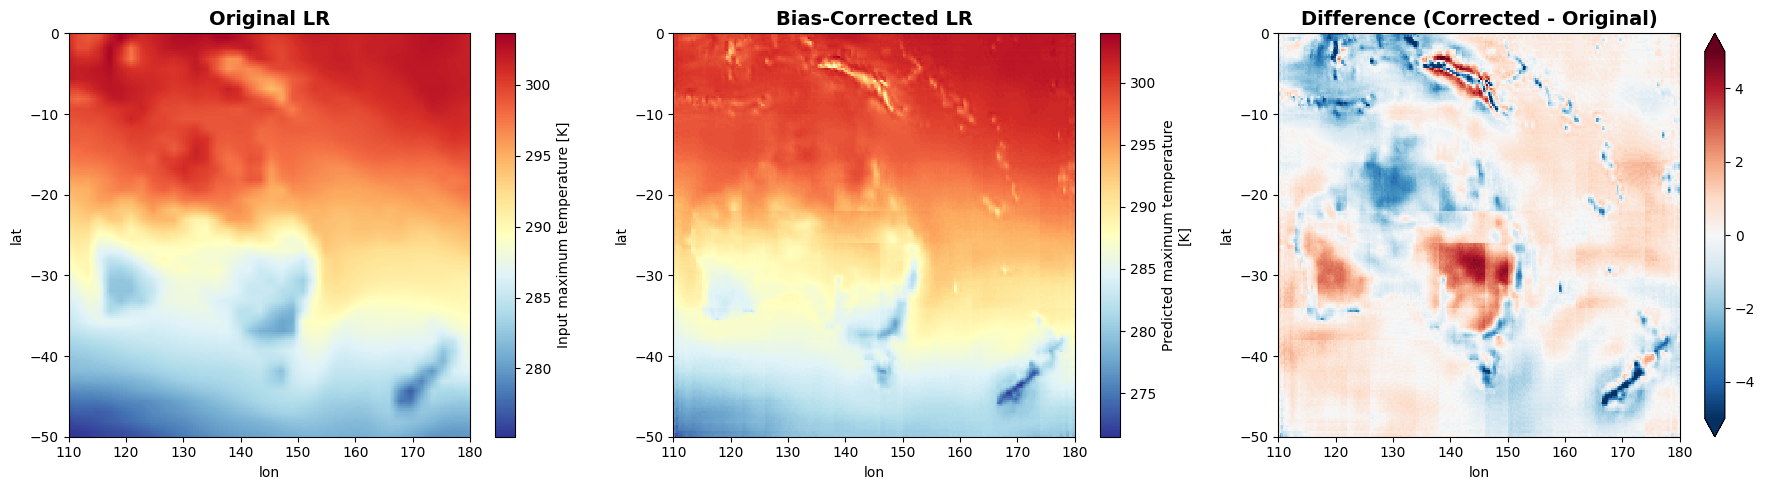


📊 Comparison plot saved to: bias_correction_comparison.png


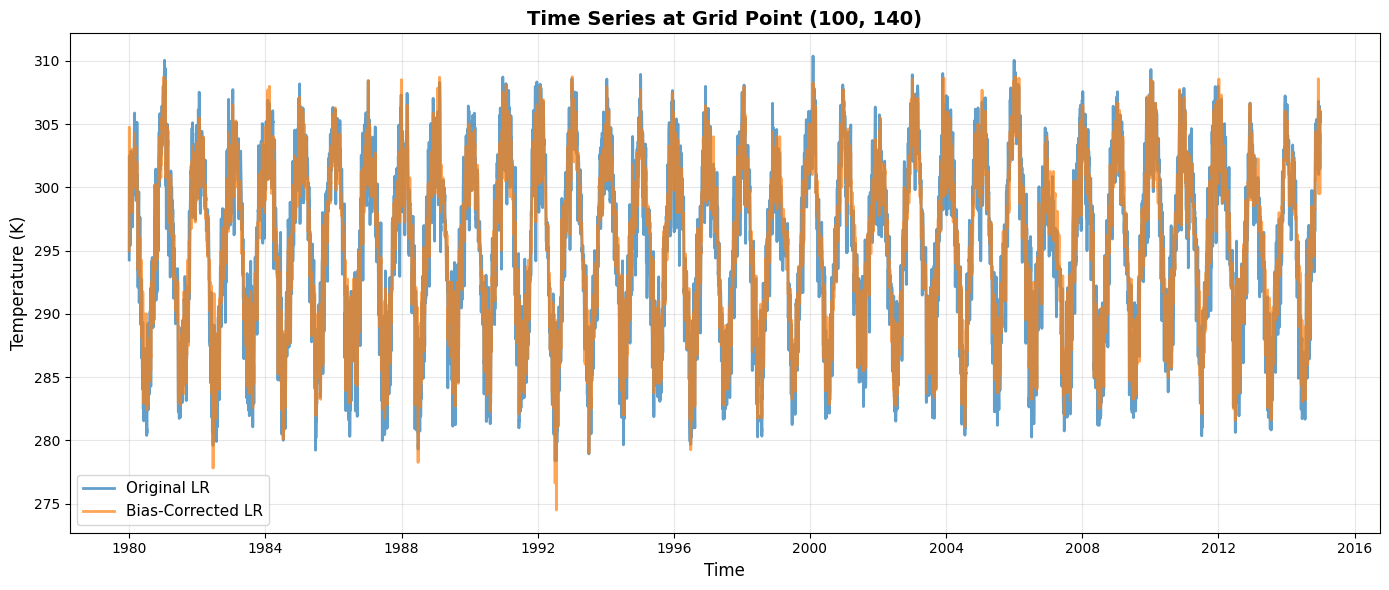

📈 Time series plot saved to: bias_correction_timeseries.png


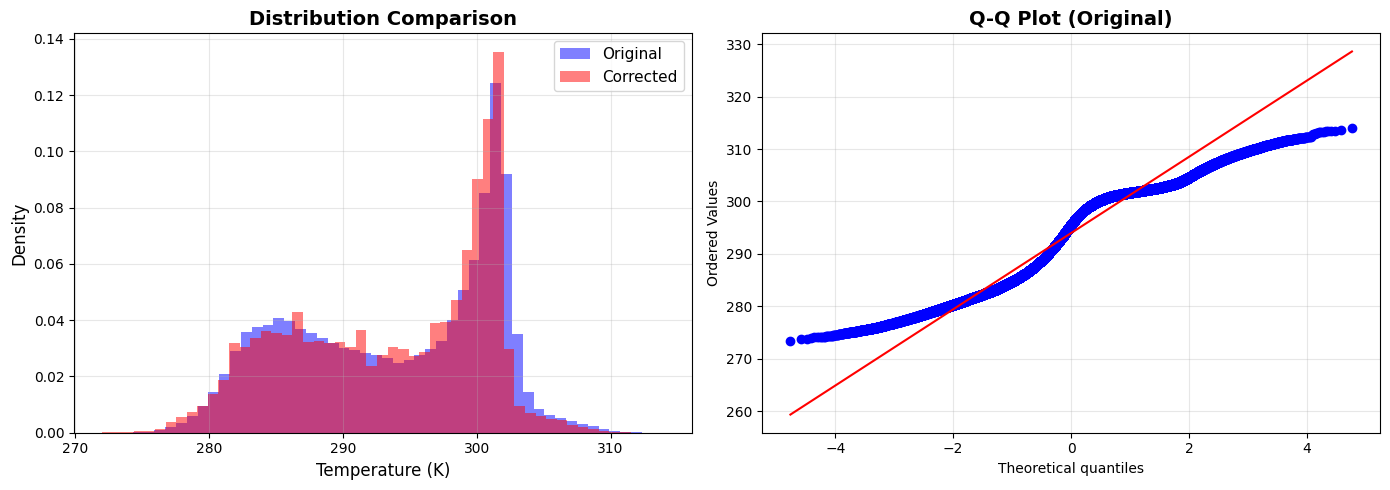

📊 Distribution plot saved to: bias_correction_distribution.png

🎉 All visualizations complete!


: 

In [ ]:

# ===== 결과 시각화 =====
import matplotlib.pyplot as plt

# 원본 데이터 로드
lr_original = xr.open_dataset(LR_PATH).tmax_input

# 특정 시점 비교
sample_time = '2014-08-18'

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 원본
lr_original.sel(time=sample_time, method='nearest').plot(
    ax=axes[0], cmap='RdYlBu_r', add_colorbar=True
)
axes[0].set_title('Original LR', fontsize=14, fontweight='bold')

# 보정
lr_corrected.sel(time=sample_time, method='nearest').plot(
    ax=axes[1], cmap='RdYlBu_r', add_colorbar=True
)
axes[1].set_title('Bias-Corrected LR', fontsize=14, fontweight='bold')

# 차이
diff = lr_corrected.sel(time=sample_time, method='nearest') - \
       lr_original.sel(time=sample_time, method='nearest')
diff.plot(ax=axes[2], cmap='RdBu_r', add_colorbar=True,
          vmin=-5, vmax=5)
axes[2].set_title('Difference (Corrected - Original)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(config['plot_dir'] + '/bias_correction_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Comparison plot saved to: bias_correction_comparison.png")

# ===== 시계열 비교 =====
# 특정 지점 선택
lat_idx, lon_idx = lr_original.shape[1]//2, lr_original.shape[2]//2

fig, ax = plt.subplots(figsize=(14, 6))

lr_original.isel(lat=lat_idx, lon=lon_idx).plot(
    ax=ax, label='Original LR', linewidth=2, alpha=0.7
)
lr_corrected.isel(lat=lat_idx, lon=lon_idx).plot(
    ax=ax, label='Bias-Corrected LR', linewidth=2, alpha=0.7
)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Temperature (K)', fontsize=12)
ax.set_title(f'Time Series at Grid Point ({lat_idx}, {lon_idx})', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config['plot_dir'] + '/bias_correction_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

print("📈 Time series plot saved to: bias_correction_timeseries.png")

# ===== 분포 비교 =====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램
axes[0].hist(lr_original.values.flatten()[::1000], bins=50, alpha=0.5, 
            label='Original', density=True, color='blue')
axes[0].hist(lr_corrected.values.flatten()[::1000], bins=50, alpha=0.5, 
            label='Corrected', density=True, color='red')
axes[0].set_xlabel('Temperature (K)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Distribution Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats as sp_stats
sp_stats.probplot(lr_original.values.flatten()[::1000], dist=sp_stats.norm, plot=axes[1])
axes[1].set_title('Q-Q Plot (Original)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config['plot_dir'] + '/bias_correction_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Distribution plot saved to: bias_correction_distribution.png")

print("\n🎉 All visualizations complete!")

In [7]:
lr_flatten = lr_original.sel(time=sample_time, method='nearest').values.flatten()
lr_corrected_flatten = lr_corrected.sel(time=sample_time, method='nearest').values.flatten()
hr_flatten = hr_original.sel(time=sample_time, method='nearest').values.flatten()




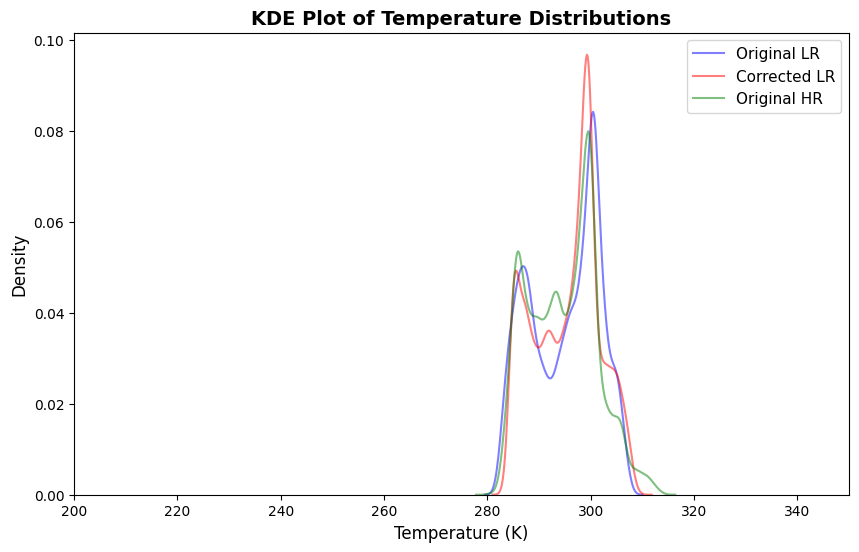

In [8]:
import seaborn as sns
plt.figure(figsize=(10, 6))
plt.xlim(200, 350)
sns.kdeplot(lr_flatten, label='Original LR', color='blue', alpha=0.5)
sns.kdeplot(lr_corrected_flatten, label='Corrected LR', color='red', alpha=0.5)
sns.kdeplot(hr_flatten, label='Original HR', color='green', alpha=0.5)

plt.xlabel('Temperature (K)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('KDE Plot of Temperature Distributions', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.show()

<Axes: ylabel='Density'>

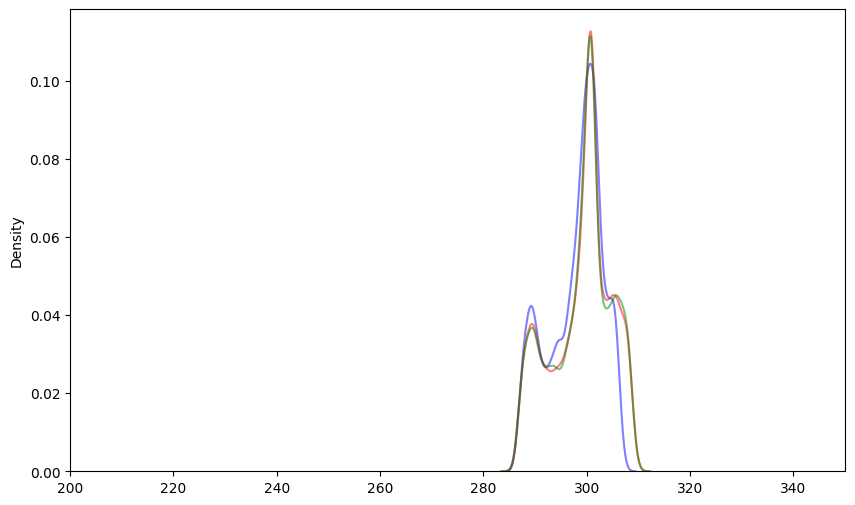

In [9]:
lr_flatten2 = lr_original.mean(dim='time').values.flatten()
lr_corrected_flatten2 = lr_corrected.mean(dim='time').values.flatten()
hr_flatten2 = hr_original.mean(dim='time').values.flatten()
plt.figure(figsize=(10, 6))
plt.xlim(200, 350)
sns.kdeplot(lr_flatten2, label='Original LR', color='blue', alpha=0.5)
sns.kdeplot(lr_corrected_flatten2, label='Corrected LR', color='red', alpha=0.5)
sns.kdeplot(hr_flatten2, label='Original HR', color='green', alpha=0.5)

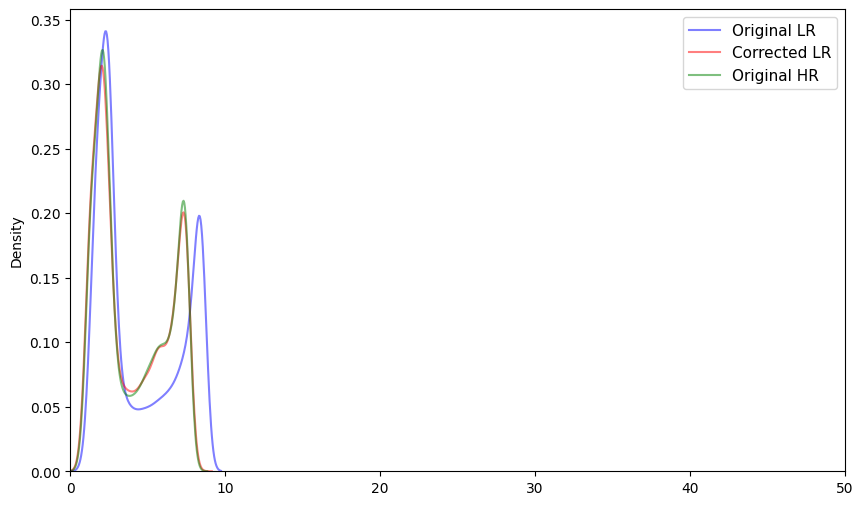

In [10]:
lr_flatten3 = lr_original.std(dim='time').values.flatten()
lr_corrected_flatten3 = lr_corrected.std(dim='time').values.flatten()
hr_flatten3 = hr_original.std(dim='time').values.flatten()
plt.figure(figsize=(10, 6))
plt.xlim(0, 50)
sns.kdeplot(lr_flatten3, label='Original LR', color='blue', alpha=0.5)
sns.kdeplot(lr_corrected_flatten3, label='Corrected LR', color='red', alpha=0.5)
sns.kdeplot(hr_flatten3, label='Original HR', color='green', alpha=0.5)
plt.legend(fontsize=11)